In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from numpy import nan

In [2]:
def FTS(T):    
    #return np.fft.fftshift( np.fft.fft(np.fft.fftshift(T)) )
    return np.fft.fftshift( np.fft.fft(np.fft.fftshift(T)) )
    #return np.fft.fft(T) 

def iFTS(T):
    return np.fft.ifftshift( np.fft.ifft(np.fft.ifftshift(T)) )    
    #return np.fft.ifft(T) 

def plh(dz, kz, r, T, lam, dx):
    """
    frensel impulse response propagation
    """
    
    if (lam*dz/(T.shape[0]*dx**2)) < 0.3:
        f = iFTS( FTS(T)*(np.exp(1j*kz*dz)) )
        
    else:
        k = 2*np.pi/lam
        #fh = 1/(1j*lam*dz)*np.exp(1j*k*(r**2)/2/dz)
        fh = np.exp(1j*k*(r**2)/2/dz)
        fh = FTS(fh) #нормировка        
        f = iFTS( FTS(T)*fh )
    return f

def rphase(dx,L,k):
    kx = np.arange(-2*pi/(2*dx), 2*pi/(2*dx), 2*pi/L)
    
    kz = np.sqrt(k**2-kx**2)
    return kz

def Lens(x, k, focus):
    r2 = x**2
    return  k*r2/(2*focus)

def circ(r,a):
    return np.abs(r) < a

class sct_object:
    aspx = 128 #number of pixels in A-scan
    lam  = .85 #All in mcm
    Xmax = 256
    zs   = 200
    
    def __init__(self,K):
        self.K = K #List scatterers coordinates
    def Ascan():
        

<h3> Testing shifting and sempling </h3>

256 / 156


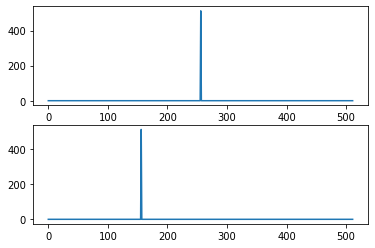

In [3]:
l = 512
kx = np.arange(-2*np.pi/(2), 2*np.pi/(2), 2*np.pi/l)
T = np.zeros(512,dtype=complex)
T += 1
fig, axes = plt.subplots(nrows=2,ncols=1)
S1 = np.abs(FTS(T))
S2 = np.abs(FTS(T*np.exp(-1j*kx*100)))
axes[0].plot( S1 )
axes[1].plot( S2 )
print(S1.argmax(), '/', S2.argmax())

<h3>Set simulator constants</h3>

In [4]:
l = 512 #samples in x direction
aspx = 128 #samples in z direction (Ascan)
dx = 0.53
dz = 2.
L  = dx*l
lam = .85
k  = 2*pi/lam

zs  = 200 #Observation plane, mcm
foc = 200 #Lens focus
B = np.zeros((aspx,l),dtype=complex)

x   = np.arange(-L/2, L/2, dx)
kx  = np.arange(-2*pi/(2*dx), 2*pi/(2*dx), 2*pi/L)
#x = x[:,np.newaxis]
#kx = kx[:,np.newaxis]
kx2 = kx**2
kz  = np.sqrt(k**2-kx**2)

<h3> Calculate B-scan using eq. 7 </h3>

We calculate field with plh() - not with eq. 3.

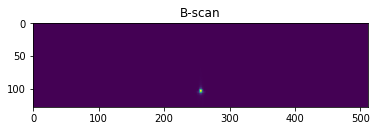

In [5]:
K = np.zeros(l,dtype=complex)
K[256] = 1

#Spectrum sempling 
spec_wight = .07 #70 nm 
Spec = np.arange(lam-spec_wight/2,lam+spec_wight/2
                 -spec_wight/aspx,spec_wight/aspx)
Spec = 2*np.pi/Spec

A = np.zeros(aspx,dtype=complex) #A-scan
sig = 1/np.sqrt(2)*40 #40 - aperture radius

for j,x0 in enumerate(x):
    r  =  np.abs(x - x0)
    r2 = r**2
    UL = ( ( np.exp(-r2/2/sig**2) ).astype(complex)
          *np.exp(-1j*k*r2/(2*foc))*circ(r,40) )
    fUL = FTS(UL)
    
    for i,k in enumerate(Spec):
        kz = np.sqrt(k**2-kx2)
        h  = np.exp(1j*kz*zs)
        A[i] = (K*( iFTS(fUL*h) )**2).sum()
    B[:,j] = iFTS(A)
plt.imshow(np.abs(B))
plt.title('B-scan');

<h2>Generate right $U_S$ </h2>

<h3> Set UL </h3>

For lens sampling the relation for pixel size mast be fulfilled: $ dx \leq \frac{f}{2D}\lambda $

dx mmust be less then 0.53 mcm


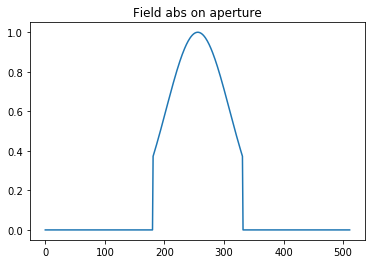

In [6]:
r = np.abs(x)

ra = 40 #Aperture radius
sig = 1/np.sqrt(2)*ra

UL = np.exp(-r**2/2/sig**2).astype(complex)
fok = 200
UL *= np.exp(-1j*Lens(x,k,fok))*circ(r,40)
plt.plot(np.abs(UL))
plt.title('Field abs on aperture')
print( 'dx mmust be less then {:.2f} mcm'.format(fok*lam/(2*(2*ra*2))) )

<b> Calculate field in XZ plane using standart scalad diffraction </b>

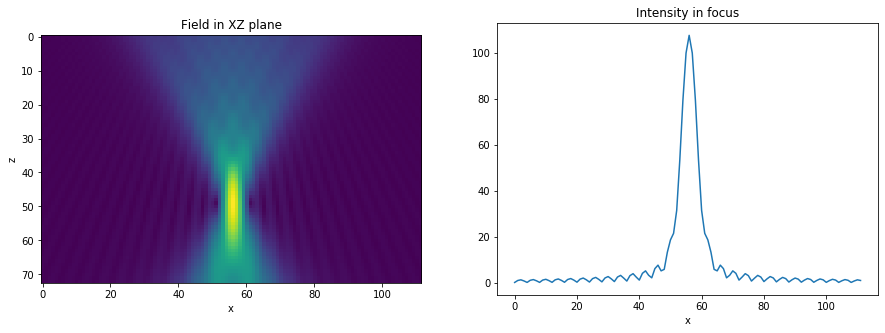

In [7]:
B = np.zeros((128,l), dtype=complex)

for zx in range(0,128):
    B[zx,:] = plh(zx*dz,kz,r,UL,lam,dx)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].imshow(np.abs(B[55:,200:312]))
axes[0].set_xlabel('x');
axes[0].set_ylabel('z');
axes[0].set_title('Field in XZ plane');

axes[1].plot(np.abs(B[100,200:312]))
axes[1].set_xlabel('x')
axes[1].set_title('Intensity in focus');

<h2> Check equations from article  </h2>

Calculate field $U_s(x_0)$ - field in dot from $x_0$ aperture from eq. 3.

$$U_s(x_0)=\int g(k_x)h(k_x)e^{ ik_x(x_s-x_0) }dk_x=FT\big(F(k_x)e^{ik_xx_s} \big) $$

<b> At first check field calculation using eq. 3. See shifting </b>

56  /  46


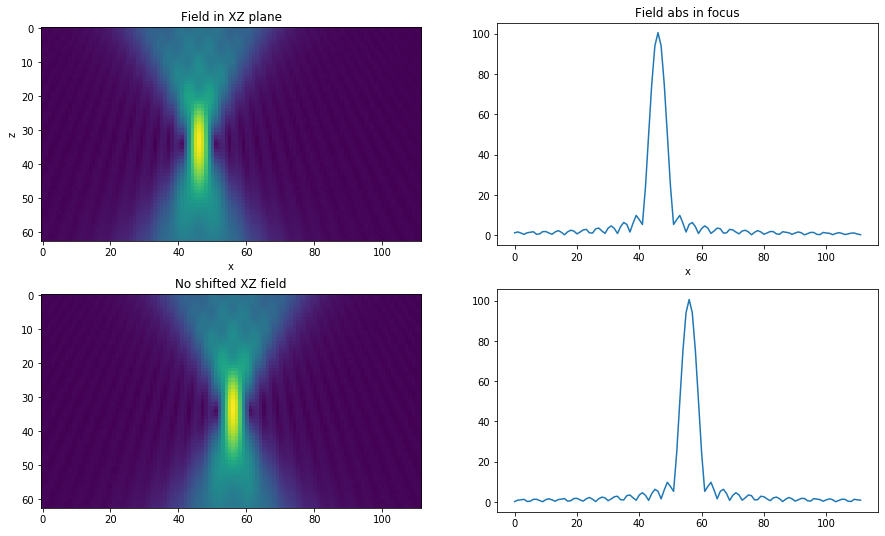

In [12]:
def temp_function(shft):
    #Btemp - field with xs = 0
    xs = shft*dx
    scl = np.sqrt(1/UL.shape[0]) #Scale
    g = scl*FTS(UL);      

    B1 = np.zeros((128,l), dtype=complex)

    for zx in range(0,128):
        zs = zx*dz
        h = (np.exp(1j*kz*zs))
        B1[zx,:] = FTS(g*h*np.exp(1j*kx*xs))
    return B1
Btemp = temp_function(0)
B1 = temp_function(-10)

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,9))
axes = axes.flatten()
    
axes[0].imshow(np.abs(B1[65:,200:312]))
axes[0].set_xlabel('x');
axes[0].set_ylabel('z');
axes[0].set_title('Field in XZ plane');

axes[1].plot(np.abs(B1[100,200:312]))
axes[1].set_xlabel('x')
axes[1].set_title('Field abs in focus')

axes[2].imshow( np.abs(Btemp[65:,200:312]) ) #Field with paramiter xs=0
axes[2].set_title('No shifted XZ field')
axes[3].plot(np.abs(Btemp[100,200:312]))

print(np.abs(Btemp[100,200:312]).argmax(),' / ',np.abs(B1[100,200:312]).argmax())

<b>Calculate B-scan using eq. 3</b>

In foucus gaussin beam wight $\rho_f$  is determined by eq.: $$ \rho_f = \frac{f}{k\rho_0} $$
there $\rho_0$ is gaussian beam wight by field level $ e^{-1} $ on the lens.
Then depth of focus is: $$ d = 2Z_R = 2\frac{\pi\rho_f^2}{\lambda} = k\rho_f^2 = \frac{f^2}{k\rho_0^2} = (k{NA}^2)^{-1} $$
For $\rho_0 = 40, k = 2\pi/0.85, f = 200; d \approx 4\mu m $


In [ ]:
Ну в целом оно как-то работает. 
Вполне можно писать класс, который строит соответствующее изображение. 
Пытаться его оптимизировать.

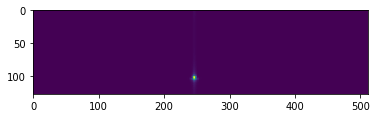

In [13]:
#Set FTS from UL:
scl = np.sqrt(1/UL.shape[0]) #Scale
g = scl*FTS(UL)

Cr = np.array([[100,256]])

#Spectrum sempling 
spec_wight = .07 #70 nm 
Spec = np.arange(lam-spec_wight/2,lam+spec_wight/2
                 -spec_wight/aspx,spec_wight/aspx)
Spec = 2*np.pi/Spec

A = np.zeros(aspx,dtype=complex) #A-scan
sig = 1/np.sqrt(2)*40 #40 - aperture radius

B  = np.zeros((aspx,l),dtype=complex)
Bt = np.zeros((aspx,l),dtype=complex)

K  = np.zeros((aspx,l),dtype=complex)
#K[100,256] = 1
#K[100,246] = 1
K[99,246] = 1
Cr = K.nonzero()

for izs,ixs,Kt in zip(Cr[0],Cr[1],K[Cr]):
    xs = (ixs-256)*dx
    zs = izs*dz
    for j,x0 in enumerate(x):
    
        Sh  = np.exp(1j*kx*(xs-x0))
        #Us = FTS( g*h*Sh ) 
        #Us = ( g*h*Sh ).sum()
    
        for i,k in enumerate(Spec):
            kz = np.sqrt(k**2-kx2)
            h  = np.exp(1j*kz*zs)
            Us = ( g*h*Sh ).sum()
            #Us = FTS( g*h*Sh ) #I will leave it for now
            #A[i] = (Kt*Us**2).sum()
            A[i] = Kt*Us**2
        Bt[:,j] = iFTS(A)
    B += Bt
plt.imshow(np.abs(B))

In [14]:
K  = np.zeros((aspx,l),dtype=complex)
K[100,256] = 1
K[100,246] = 1
Cr = K.nonzero()
for izs,ixs,Kt in zip(Cr[0],Cr[1],K[Cr]):
    print(Kt)

(1+0j)
(1+0j)


In [ ]:
plt.plot(np.abs(B[64,:]))

In [ ]:
64*2